# Import Dependencies

In [26]:
import pandas as pd
import os 
import numpy as np 
import torch 
import seaborn as sns
from collections import Counter 
from torchvision import datasets ,transforms
from torch.utils.data import DataLoader, Subset
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch.optim as optim 
import torchvision 
from torchvision  import models
import math
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score


In [2]:
DATASET_DIR='/kaggle/input/plant-village/PlantVillage'
dir =os.listdir(DATASET_DIR)
for file_name in dir :
    print(file_name)
print(len(dir))

Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Pepper__bell___healthy
Potato___Late_blight
Tomato_Late_blight
Potato___Early_blight
Tomato__Tomato_mosaic_virus
15


### we have a 15 class  

In [3]:
class Config:
    DATA_DIR = DATASET_DIR
    BATCH_SIZE = 32
    IMAGE_SIZE = (224, 224)
    SEED = 42
    NORM_MEAN = [0.485, 0.456, 0.406]
    NORM_STD = [0.229, 0.224, 0.225]

# split data 

In [4]:

train_transform = transforms.Compose([
    transforms.Resize(Config.IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(Config.NORM_MEAN,Config.NORM_STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize(Config.IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(Config.NORM_MEAN,Config.NORM_STD)
])


In [5]:
FULL_DATASET=datasets.ImageFolder(root=DATASET_DIR)

--- Distribution For 15 classes 
Pepper__bell___Bacterial_spot: 997 images
Pepper__bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Tomato_Bacterial_spot: 2127 images
Tomato_Early_blight: 1000 images
Tomato_Late_blight: 1909 images
Tomato_Leaf_Mold: 952 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato__Target_Spot: 1404 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 images
Tomato__Tomato_mosaic_virus: 373 images
Tomato_healthy : 1591 images


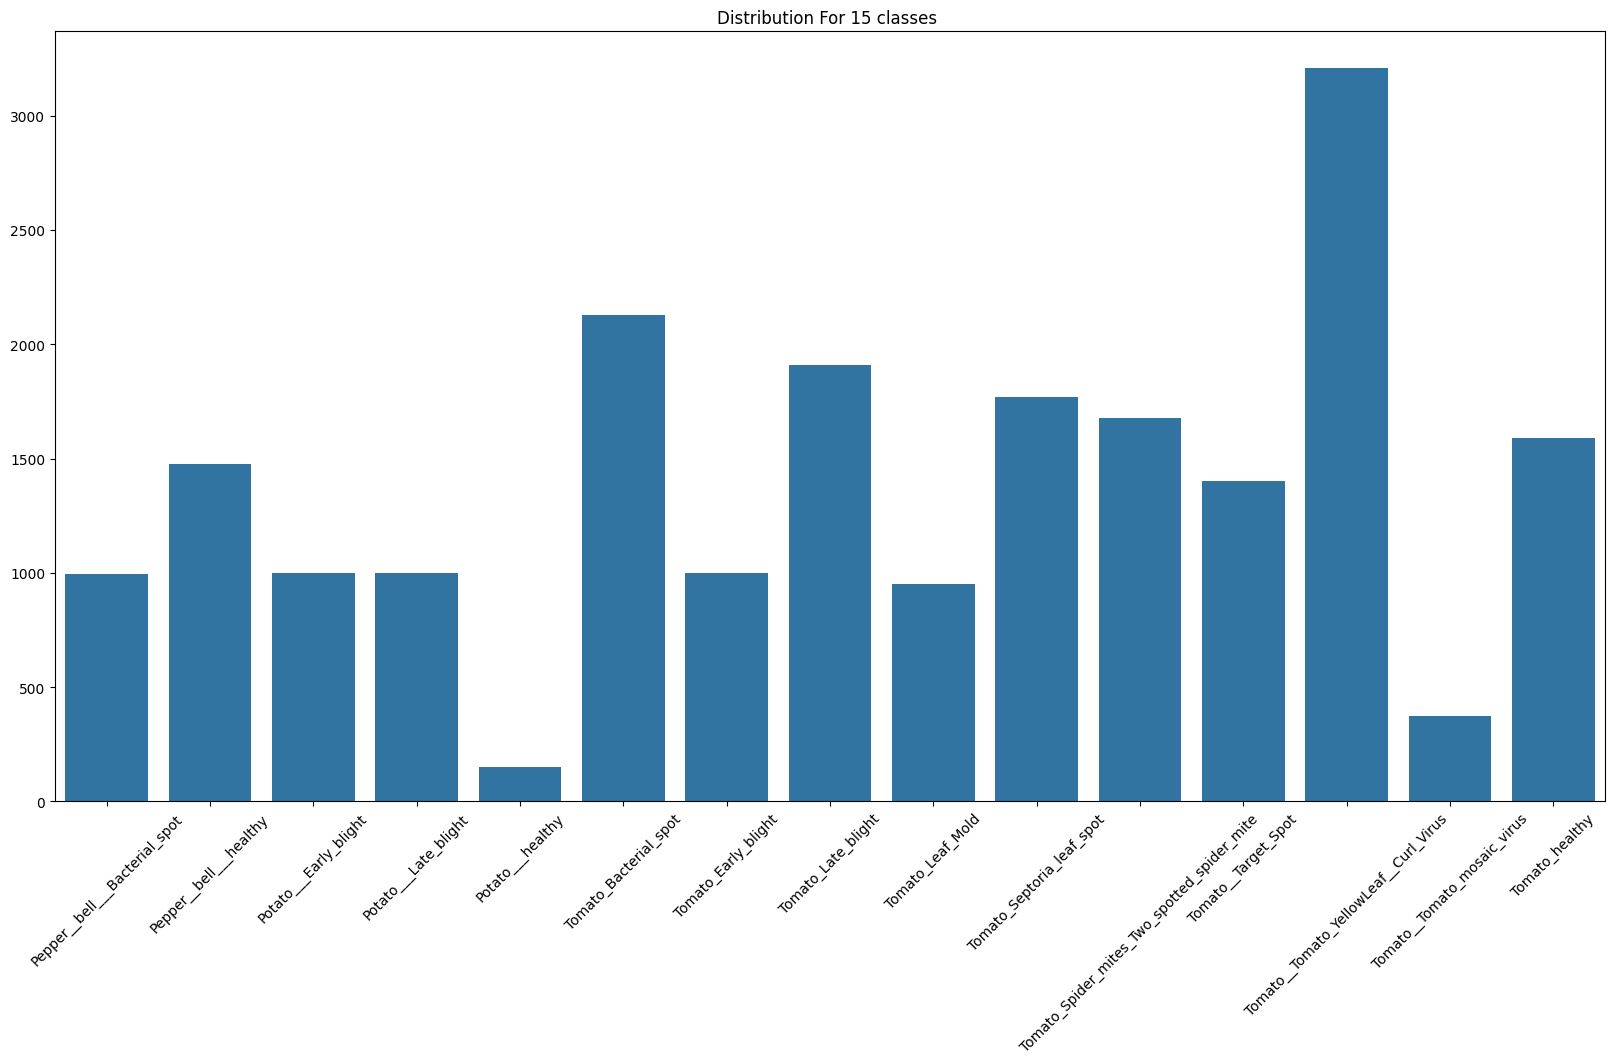

In [6]:
# class distrubution for 15 class 
def check_Distribution(dataset):
    counts=Counter(dataset.targets)
    class_names=dataset.classes
    print("--- Distribution For 15 classes ")
    for idx, count in counts.items():
        print(f"{class_names[idx]:<15}: {count} images")
    
    plt.figure(figsize=(20, 10))
    sns.barplot(x=[class_names[i] for i in counts.keys()], y=list(counts.values()))
    plt.title("Distribution For 15 classes ")
    plt.xticks(rotation=45)
    plt.show()
check_Distribution(FULL_DATASET)

In [7]:
# split data into train and test and val 

def split_data(data_dir):
    FULL_DATASET=datasets.ImageFolder(root=data_dir)
    indices=np.arange(len(FULL_DATASET))
    label=FULL_DATASET.targets
    train_idx,temp_idx,_,temp_labels=train_test_split(
        indices,label,test_size=0.2,stratify=label,random_state=Config.SEED
    )

    
    val_idx,test_idx=train_test_split(
        temp_idx,test_size=0.5,stratify=temp_labels,random_state=Config.SEED
    )
    
    train_data =Subset(datasets.ImageFolder(data_dir, transform=train_transform), train_idx)
    val_data =  Subset(datasets.ImageFolder(data_dir, transform=val_test_transform), val_idx)
    test_data = Subset(datasets.ImageFolder(data_dir, transform=val_test_transform), test_idx)
    
    train_loader=DataLoader(train_data,batch_size=Config.BATCH_SIZE,shuffle=True)
    test_loader= DataLoader(test_data,batch_size=Config.BATCH_SIZE,shuffle=False)
    val_loader=  DataLoader(val_data,batch_size=Config.BATCH_SIZE,shuffle=False)

    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = split_data(Config.DATA_DIR)




In [8]:
images, labels = next(iter(train_loader))
print(images.shape)

torch.Size([32, 3, 224, 224])


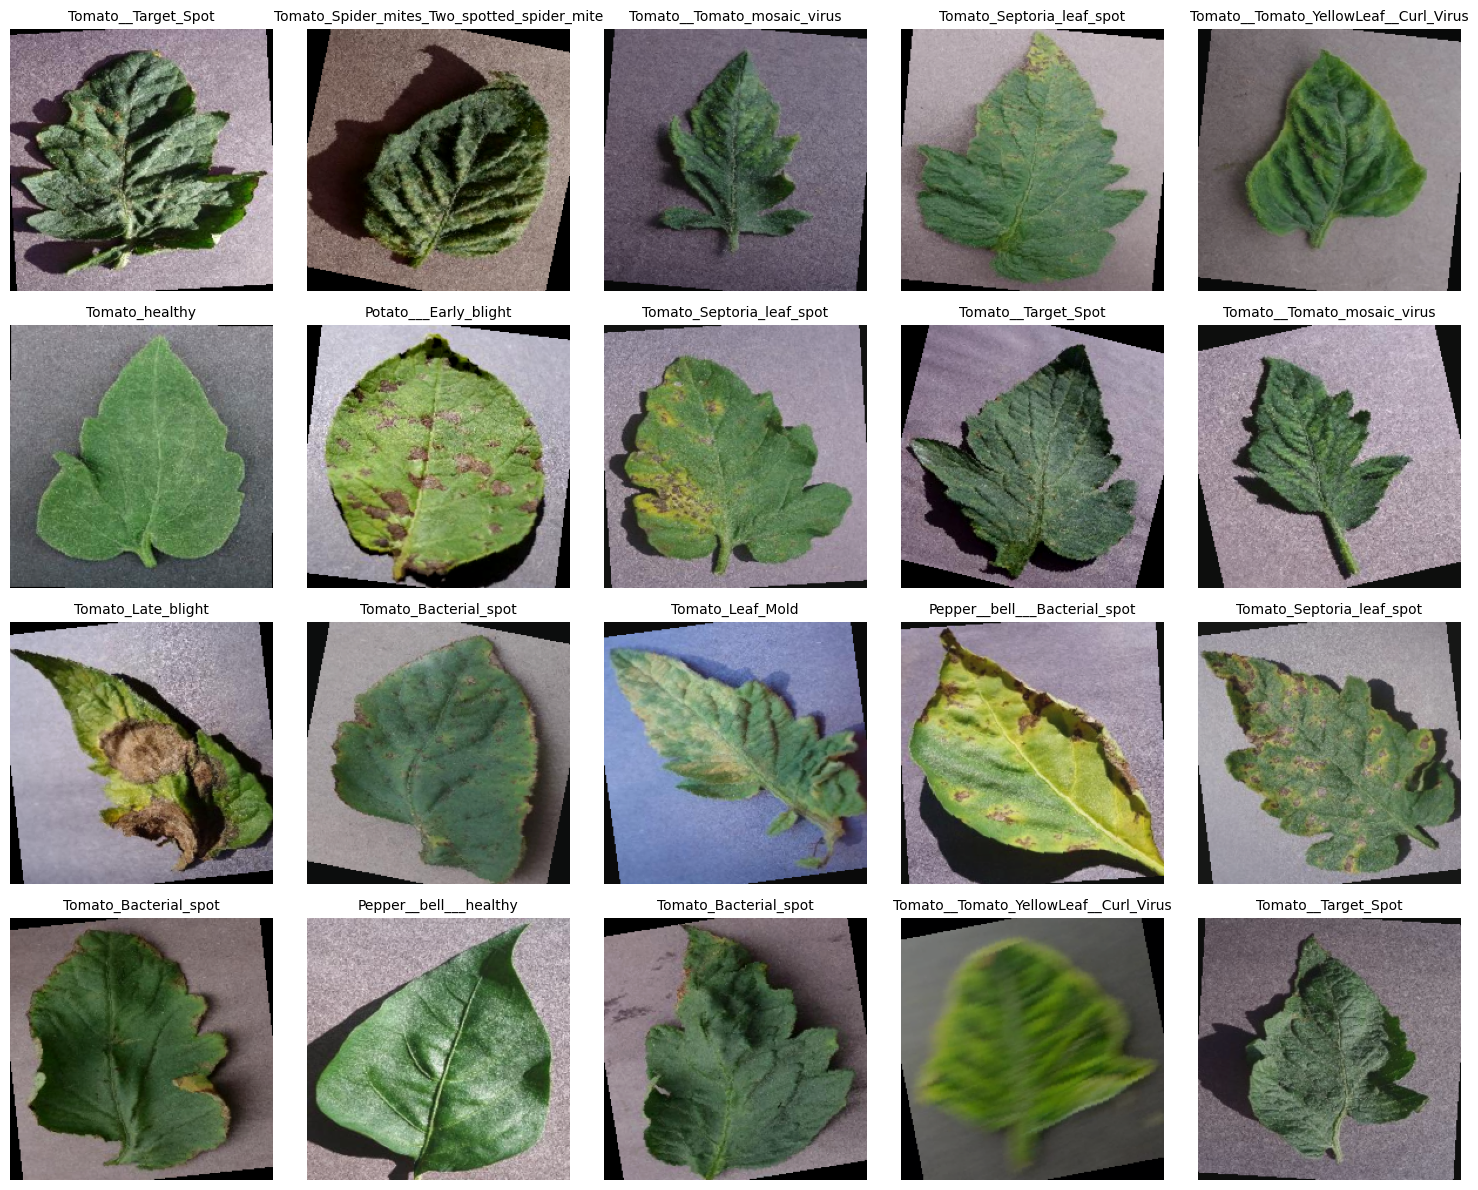

In [11]:

def show_loader_samples(dataloader, class_names, num_samples=20):
 
    images, labels = next(iter(dataloader))
    
    cols = 5
    rows = math.ceil(num_samples / cols)
    plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).cpu().numpy()
    
        mean = np.array(Config.NORM_MEAN)
        std = np.array(Config.NORM_STD)
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)

        plt.title(f"{class_names[labels[i]]}", fontsize=10)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


show_loader_samples(train_loader, FULL_DATASET.classes)

# Model Building

# train the model 

In [ ]:
class PlantResNet50(nn.Module):
    def __init__(self, num_classes=15):
        super(PlantResNet50, self).__init__()
        

        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT,)
        
        for param in self.resnet.parameters():
            param.requires_grad = False

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [ ]:
device=torch.device ('cuda' if torch.cuda.is_available()else "cpu")


In [17]:
model_resent=PlantResNet50(num_classes=15).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model_resent.parameters(),lr=0.01)

In [19]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    return running_loss/len(dataloader), 100.*correct/total

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name="best_model.pth"):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            loop.set_postfix({"Loss": f"{loss.item():.4f}", "Acc": f"{100.*correct/total:.2f}%"})
        
        # --- Validation Phase ---
        v_loss, v_acc = validate(model, val_loader, criterion, device)
        
        # Save History
        history['train_loss'].append(train_loss/len(train_loader))
        history['train_acc'].append(100.*correct/total)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)
        
        
        print(f"Summary: Train Acc: {history['train_acc'][-1]:.2f}% | Val Acc: {v_acc:.2f}%")
        
        # Save Best Model Checkpoint
        if v_acc > best_acc:
            best_acc = v_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'acc': v_acc,
            }, model_name)
            print(f"🏆 New Best Model Saved!")
            
    return history

In [21]:

history = train_model(
    model=model_resent,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20,
    device=device,
    model_name="resnet50_plant_model.pth"
)

Epoch 1/10:   0%|          | 0/516 [00:00<?, ?it/s]

Summary: Train Acc: 71.51% | Val Acc: 88.81%
🏆 New Best Model Saved!


Epoch 2/10:   0%|          | 0/516 [00:00<?, ?it/s]

Summary: Train Acc: 79.29% | Val Acc: 89.58%
🏆 New Best Model Saved!


Epoch 3/10:   0%|          | 0/516 [00:00<?, ?it/s]

Summary: Train Acc: 81.09% | Val Acc: 91.28%
🏆 New Best Model Saved!


Epoch 4/10:   0%|          | 0/516 [00:00<?, ?it/s]

Summary: Train Acc: 82.47% | Val Acc: 92.15%
🏆 New Best Model Saved!


Epoch 5/10:   0%|          | 0/516 [00:00<?, ?it/s]

Summary: Train Acc: 83.74% | Val Acc: 92.05%


Epoch 6/10:   0%|          | 0/516 [00:00<?, ?it/s]

Summary: Train Acc: 84.73% | Val Acc: 91.76%


Epoch 7/10:   0%|          | 0/516 [00:00<?, ?it/s]

Summary: Train Acc: 84.56% | Val Acc: 93.22%
🏆 New Best Model Saved!


Epoch 8/10:   0%|          | 0/516 [00:00<?, ?it/s]

Summary: Train Acc: 85.12% | Val Acc: 91.91%


Epoch 9/10:   0%|          | 0/516 [00:00<?, ?it/s]

Summary: Train Acc: 85.11% | Val Acc: 91.42%


Epoch 10/10:   0%|          | 0/516 [00:00<?, ?it/s]

Summary: Train Acc: 85.18% | Val Acc: 91.67%


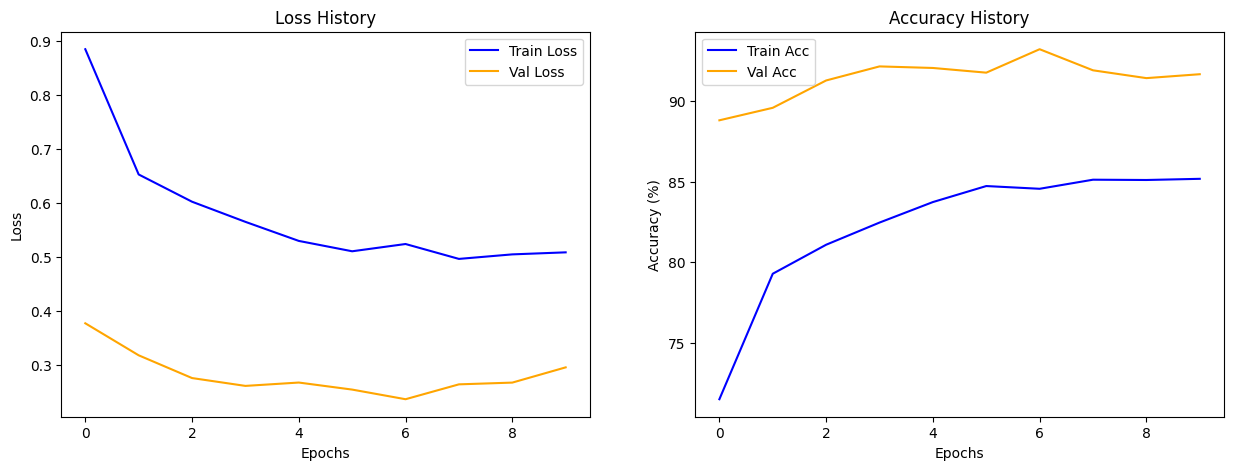

In [22]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Val Loss', color='orange')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()


    ax2.plot(history['train_acc'], label='Train Acc', color='blue')
    ax2.plot(history['val_acc'], label='Val Acc', color='orange')
    ax2.set_title('Accuracy History')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.show()


plot_history(history)

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


--- Classification Report ---
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.92      0.94       100
                     Pepper__bell___healthy       0.97      0.99      0.98       148
                      Potato___Early_blight       0.99      0.97      0.98       100
                       Potato___Late_blight       0.89      0.94      0.91       100
                           Potato___healthy       1.00      0.40      0.57        15
                      Tomato_Bacterial_spot       0.98      0.87      0.92       213
                        Tomato_Early_blight       0.87      0.81      0.84       100
                         Tomato_Late_blight       0.94      0.93      0.93       191
                           Tomato_Leaf_Mold       0.91      0.94      0.92        95
                  Tomato_Septoria_leaf_spot       0.83      0.93      0.88       177
Tomato_Spider_mites_Two_spotted_s

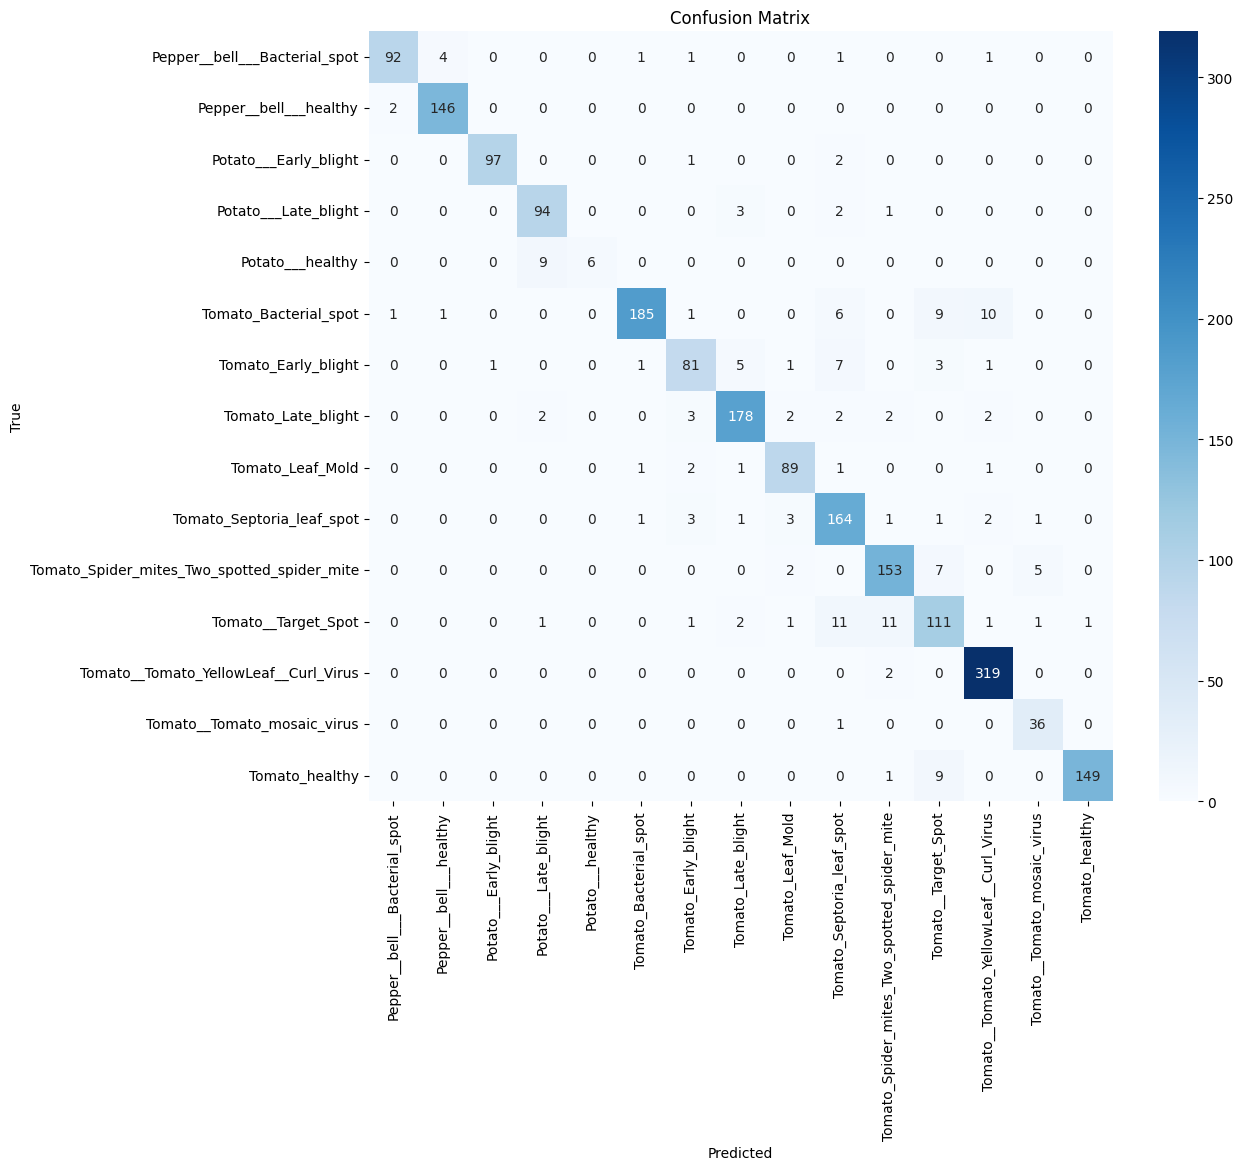

In [30]:
def evaluate_model(model, dataloader, class_names):
    checkpoint = torch.load('/kaggle/working/resnet50_plant_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)


    
    accuracy = accuracy_score(all_labels, all_preds) * 100
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\n{'='*70}")
    print(f"SUMMARY METRICS")
    print(f"{'='*70}")
    print(f"Accuracy:         {accuracy:.2f}%")
    print(f"Weighted F1:      {weighted_f1:.4f} ({weighted_f1*100:.2f}%)")
    print(f"Macro Avg F1:     {report_dict['macro avg']['f1-score']:.4f}")
    print(f"{'='*70}")


    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model_resent, test_loader, FULL_DATASET.classes)

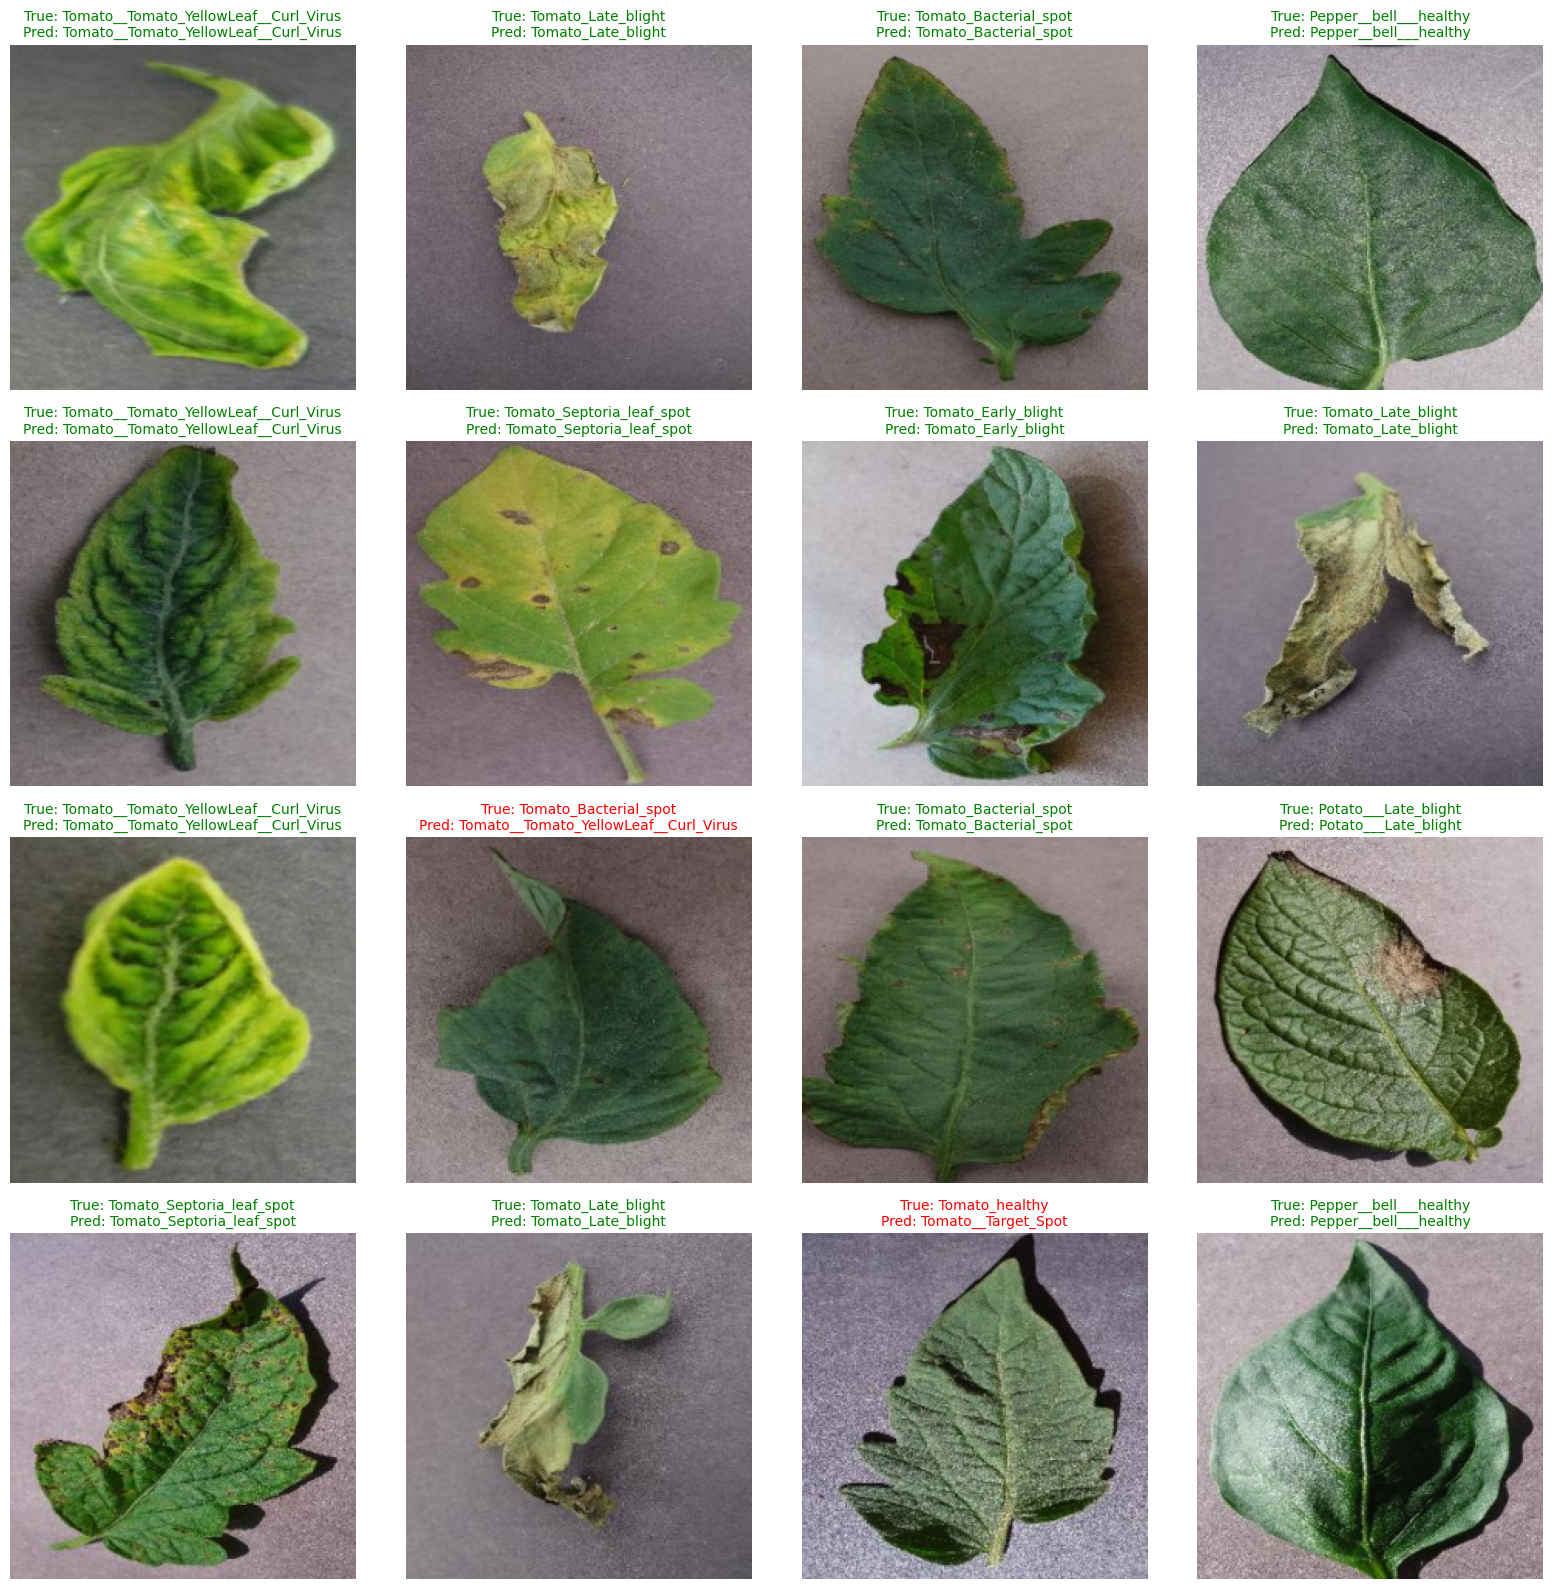

In [29]:
def show_prediction_batch(loader, model, device, class_names):
    checkpoint = torch.load('/kaggle/working/resnet50_plant_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    inputs, labels = next(iter(loader))
    inputs, labels = inputs.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    fig = plt.figure(figsize=(16, 16))
    
    for i in range(min(16, len(inputs))):
        ax = fig.add_subplot(4, 4, i+1)
        
        img = inputs[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        
        actual_cls = class_names[labels[i].item()]
        pred_cls = class_names[preds[i].item()]
        color = 'green' if actual_cls == pred_cls else 'red'
        
        ax.set_title(f"True: {actual_cls}\nPred: {pred_cls}", color=color, fontsize=10)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

show_prediction_batch(test_loader, model_resent, device, FULL_DATASET.classes)